In [1]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    run_on_colab = True
else:
    print('Not running on CoLab')
    run_on_colab = False
if run_on_colab:
    from google.colab import drive
    
    drive.mount('/drive', force_remount=True)

Running on CoLab
Mounted at /drive


In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 148 µs (started: 2021-06-10 21:14:21 +00:00)


In [3]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

time: 2 s (started: 2021-06-10 21:14:23 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
import tensorflow as tf
print("Using Keras",tf.keras.__version__)

Using Keras 2.5.0
time: 1.48 ms (started: 2021-06-10 21:14:25 +00:00)


In [5]:
window_length = 10
timeframe = "15minutes"
classes = 2
candles = 1
network = None
scaler = None

time: 1.87 ms (started: 2021-06-10 21:14:34 +00:00)


In [6]:
train_df = pd.read_csv("/drive/My Drive/disertation/train_df_{}_{}_candles_{}_class.csv".format(timeframe, candles, classes))
train_df = train_df.set_index("open_time")

time: 856 ms (started: 2021-06-10 21:16:59 +00:00)


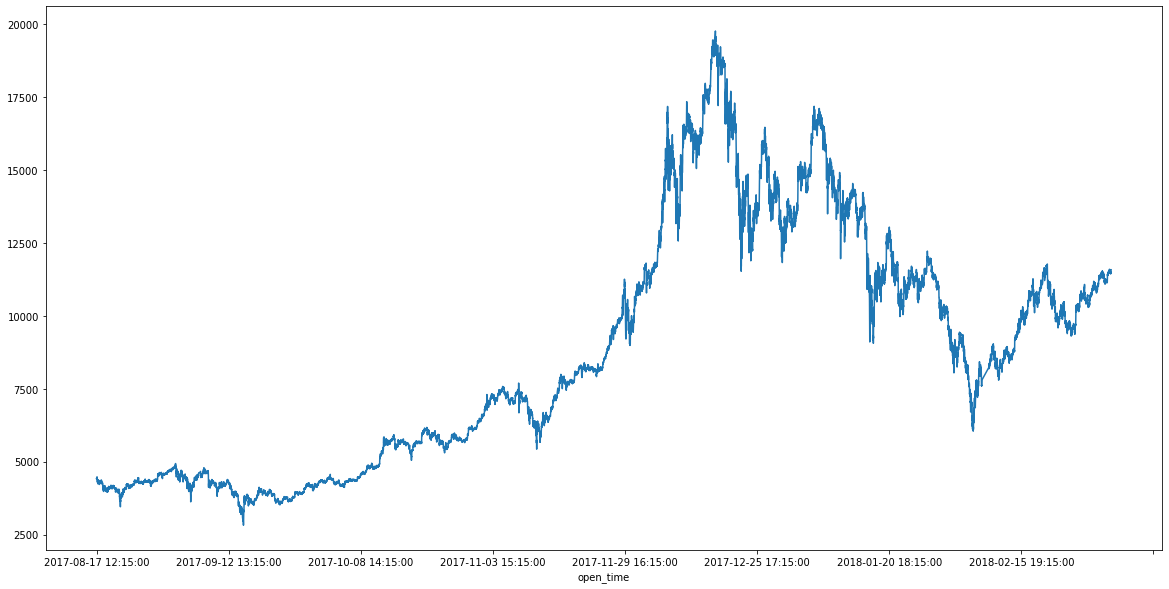

time: 274 ms (started: 2021-06-10 21:17:00 +00:00)


In [7]:
train_df["close"].plot()

In [8]:
train_df.drop(columns=["close"],inplace=True)
train_df.index = pd.to_datetime(train_df.index)

time: 8.66 ms (started: 2021-06-10 21:17:02 +00:00)


In [9]:
data = train_df.to_numpy()
X = data[:,:-1]
Y = data[:,-1]

X.shape, Y.shape

((19200, 27), (19200,))

time: 6.82 ms (started: 2021-06-10 21:17:04 +00:00)


In [10]:
def extend_dataset_with_window_length(X, Y, window_length=window_length):
    new_x = []
    for i in range(len(X) - window_length+1):
        lst = []
        for j in range(i, i+window_length):
            lst.extend(X[j])
        new_x.append(lst)
    return np.array(new_x), Y[window_length-1:]

time: 3.27 ms (started: 2021-06-10 21:17:06 +00:00)


In [11]:
X, Y = extend_dataset_with_window_length(X,Y)
X.shape, Y.shape

((19191, 270), (19191,))

time: 1.26 s (started: 2021-06-10 21:17:08 +00:00)


In [12]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

time: 46.1 ms (started: 2021-06-10 21:17:12 +00:00)


In [13]:
scaler_path = "/drive/My Drive/disertation/nns/nn_scaler_network_model_{}_{}.save".format(timeframe, window_length)
if scaler:
    joblib.dump(scaler, scaler_path)
else:
    scaler = joblib.load(scaler_path)

time: 152 ms (started: 2021-06-10 21:17:14 +00:00)


In [14]:
def get_subsample_same_distribution(X,Y, p=0.1):
    ys = pd.Series(Y)
    vs = ys.value_counts()
    original_indexes = []
    for idx in vs.index:
        required = int(p * vs[idx])
        print(required)
        original_indexes.extend(ys[ys==idx].sample(n=required, replace=False).index)
    return X[original_indexes], Y[original_indexes]

time: 3.41 ms (started: 2021-06-10 21:17:18 +00:00)


In [15]:
a,b = np.unique(Y, return_counts=True)
print("buy hold sell %")
print(b)
print(b / sum(b))

buy hold sell %
[10102  9089]
[0.52639258 0.47360742]
time: 3.34 ms (started: 2021-06-10 21:17:20 +00:00)


In [16]:
def get_equal_class_distribution(X,Y):
    ys = pd.Series(Y)
    vs = ys.value_counts()
    required_of_each_class = vs.min()
    original_indexes = []
    for idx in vs.index:
        original_indexes.extend(ys[ys==idx].sample(n=required_of_each_class, replace=False).index)
    return X[original_indexes], Y[original_indexes]

time: 3.38 ms (started: 2021-06-10 21:17:24 +00:00)


In [17]:
X,Y = get_equal_class_distribution(X,Y)
# X, Y = get_subsample_same_distribution(X,Y)

buy hold sell %
[9089 9089]
[0.5 0.5]
time: 46.4 ms (started: 2021-06-10 21:17:40 +00:00)


In [44]:
a,b = np.unique(Y, return_counts=True)
print("buy hold sell %")
print(b)
print(b / sum(b))

buy hold sell %
[9089 9089]
[0.5 0.5]
time: 5.46 ms (started: 2021-06-10 21:52:17 +00:00)


In [308]:
attempt_number = 16

network = models.Sequential()
network.add(layers.Dense(256, activation='sigmoid', input_shape=(len(X[0]),)))
network.add(layers.Dense(256, activation='sigmoid'))
network.add(layers.Dense(256, activation='sigmoid'))


if classes == 2:
    network.add(layers.Dense(1, activation="sigmoid"))
else:
    network.add(layers.Dense(classes, activation="softmax"))

network.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 256)               69376     
_________________________________________________________________
dense_65 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_66 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 257       
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
_________________________________________________________________
time: 39.3 ms (started: 2021-06-10 23:31:46 +00:00)


In [309]:
if classes == 2:
    loss = "binary_crossentropy"
else:
    loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam( learning_rate=0.001)
network.compile(optimizer='adam', loss=loss, metrics=['accuracy', tf.keras.metrics.AUC()],)

time: 13.6 ms (started: 2021-06-10 23:31:46 +00:00)


In [310]:
if classes == 3:
    Y = to_categorical(Y)
X.shape, Y.shape

((18178, 270), (18178,))

time: 5.87 ms (started: 2021-06-10 23:31:46 +00:00)


In [311]:
checkpoint_filepath = '/drive/My Drive/disertation/checkpoints/checkpoint-{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callback_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

time: 5.33 ms (started: 2021-06-10 23:31:47 +00:00)


In [312]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle=True)
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((14542, 270), (3636, 270), (14542,), (3636,))

time: 29.5 ms (started: 2021-06-10 23:31:48 +00:00)


In [313]:
history = network.fit(X_train, y_train, epochs=400, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[model_checkpoint_callback, callback_early_stop])

Epoch 1/400
455/455 [==============================] - 3s 5ms/step - loss: 0.6983 - accuracy: 0.5012 - auc_16: 0.5001 - val_loss: 0.6971 - val_accuracy: 0.5000 - val_auc_16: 0.4997
Epoch 2/400
455/455 [==============================] - 2s 4ms/step - loss: 0.6969 - accuracy: 0.4931 - auc_16: 0.4953 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_auc_16: 0.4997
Epoch 3/400
455/455 [==============================] - 2s 4ms/step - loss: 0.6963 - accuracy: 0.4969 - auc_16: 0.4920 - val_loss: 0.6933 - val_accuracy: 0.5000 - val_auc_16: 0.5011
Epoch 4/400
455/455 [==============================] - 2s 4ms/step - loss: 0.6957 - accuracy: 0.5042 - auc_16: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc_16: 0.5003
Epoch 5/400
455/455 [==============================] - 2s 4ms/step - loss: 0.6955 - accuracy: 0.5050 - auc_16: 0.5014 - val_loss: 0.6998 - val_accuracy: 0.5000 - val_auc_16: 0.5025
Epoch 6/400
455/455 [==============================] - 2s 4ms/step - loss: 0.6953 - accuracy: 0

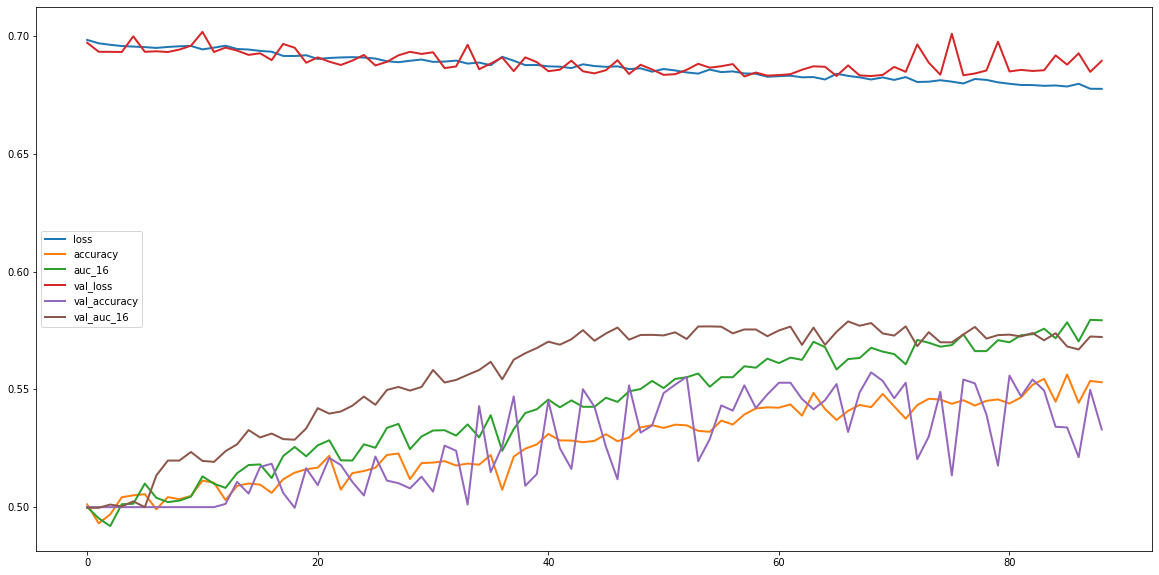

time: 40.5 s (started: 2021-06-10 23:34:30 +00:00)


In [314]:
pd.DataFrame(history.history).plot(lw=2);

In [326]:
Y_train_predicted = network.predict_classes(X)

print(np.array(np.unique(Y, return_counts=True)).T)

a,b = np.unique(Y, return_counts=True)
print("buy hold sell %")
print(b / sum(b))

print(np.array(np.unique(Y_train_predicted, return_counts=True)).T)

a,b = np.unique(Y_train_predicted, return_counts=True)
print("buy hold sell %")
print(b / sum(b))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[0.000e+00 9.089e+03]
 [1.000e+00 9.089e+03]]
buy hold sell %
[0.5 0.5]
[[    0 10841]
 [    1  7337]]
buy hold sell %
[0.59638024 0.40361976]
time: 503 ms (started: 2021-06-10 23:44:40 +00:00)


In [316]:
print(metrics.confusion_matrix(Y, Y_train_predicted))

# Print the precision and recall, among other metrics
print(metrics.classification_report(Y, Y_train_predicted, digits=3))

[[5923 3166]
 [4918 4171]]
              precision    recall  f1-score   support

         0.0      0.546     0.652     0.594      9089
         1.0      0.568     0.459     0.508      9089

    accuracy                          0.555     18178
   macro avg      0.557     0.555     0.551     18178
weighted avg      0.557     0.555     0.551     18178

time: 50.3 ms (started: 2021-06-10 23:35:11 +00:00)


In [317]:
import os
model_file = "/drive/My Drive/disertation/nns/network_attempt_{}__{}_{}_candles_{}_class_{}_window.h5".format(attempt_number, timeframe, candles, classes, window_length)
history_model_file = "/drive/My Drive/disertation/nns/history_network_attempt_{}__{}_{}_candles_{}_class_{}_window.h5".format(attempt_number, timeframe, candles, classes, window_length)

if os.path.exists(model_file):
    raise Exception("file exists!")

if network:
    network.save(model_file)
else:
    from keras.models import load_model
    network = load_model(model_file)

time: 47.5 ms (started: 2021-06-10 23:35:11 +00:00)


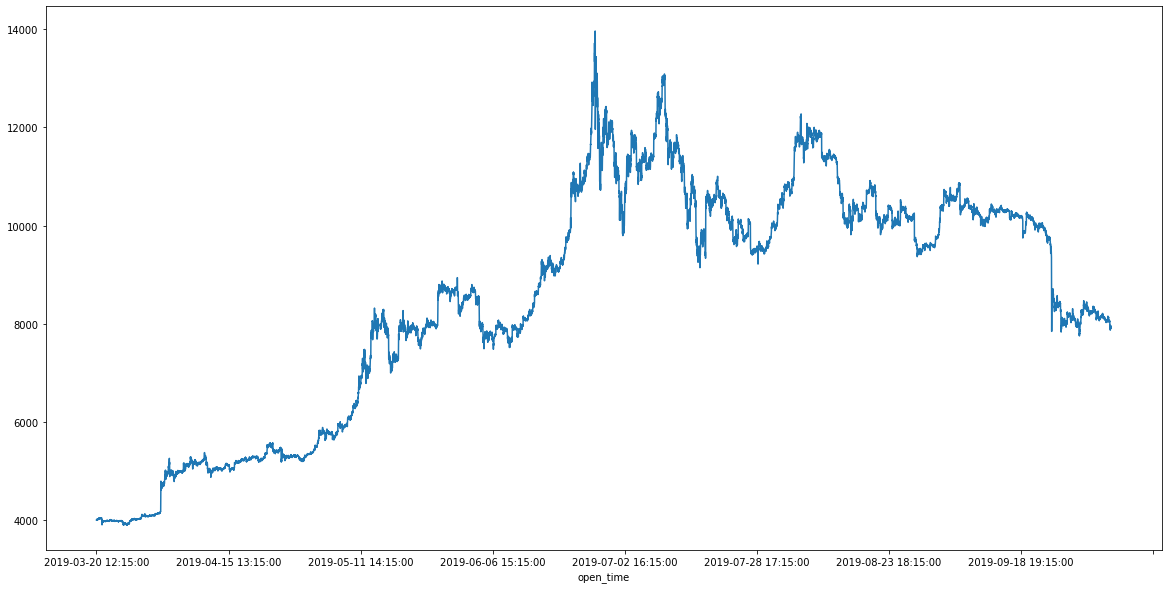

time: 357 ms (started: 2021-06-10 23:35:11 +00:00)


In [318]:
tune_df = pd.read_csv("/drive/My Drive/disertation/tune_df_{}_{}_candles_{}_class.csv".format(timeframe, candles, classes))
tune_df = tune_df.set_index("open_time")
tune_df["close"].plot()

In [319]:
tune_df.drop(columns=["close"],inplace=True)

data = tune_df.to_numpy()
X_tune = data[:,:-1]
Y_tune = data[:,-1]

X_tune, Y_tune = extend_dataset_with_window_length(X_tune, Y_tune)

X_tune = scaler.transform(X_tune)
X_tune.shape, Y_tune.shape

((19191, 270), (19191,))

time: 1.25 s (started: 2021-06-10 23:35:12 +00:00)


In [320]:
Y_tune_predicted = network.predict_classes(X_tune)

print(np.array(np.unique(Y_tune, return_counts=True)).T)
a,b = np.unique(Y_tune, return_counts=True)
print("buy hold sell %")
print(b / sum(b))

print(np.array(np.unique(Y_tune_predicted, return_counts=True)).T)
a,b = np.unique(Y_tune_predicted, return_counts=True)
print("buy hold sell %")
print(b / sum(b))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[0.000e+00 9.768e+03]
 [1.000e+00 9.423e+03]]
buy hold sell %
[0.50898859 0.49101141]
[[    0 14106]
 [    1  5085]]
buy hold sell %
[0.73503205 0.26496795]
time: 673 ms (started: 2021-06-10 23:35:13 +00:00)


In [321]:
print(metrics.confusion_matrix(Y_tune, Y_tune_predicted))
print(metrics.classification_report(Y_tune, Y_tune_predicted, digits=3))

[[7390 2378]
 [6716 2707]]
              precision    recall  f1-score   support

         0.0      0.524     0.757     0.619      9768
         1.0      0.532     0.287     0.373      9423

    accuracy                          0.526     19191
   macro avg      0.528     0.522     0.496     19191
weighted avg      0.528     0.526     0.498     19191

time: 58.2 ms (started: 2021-06-10 23:35:14 +00:00)


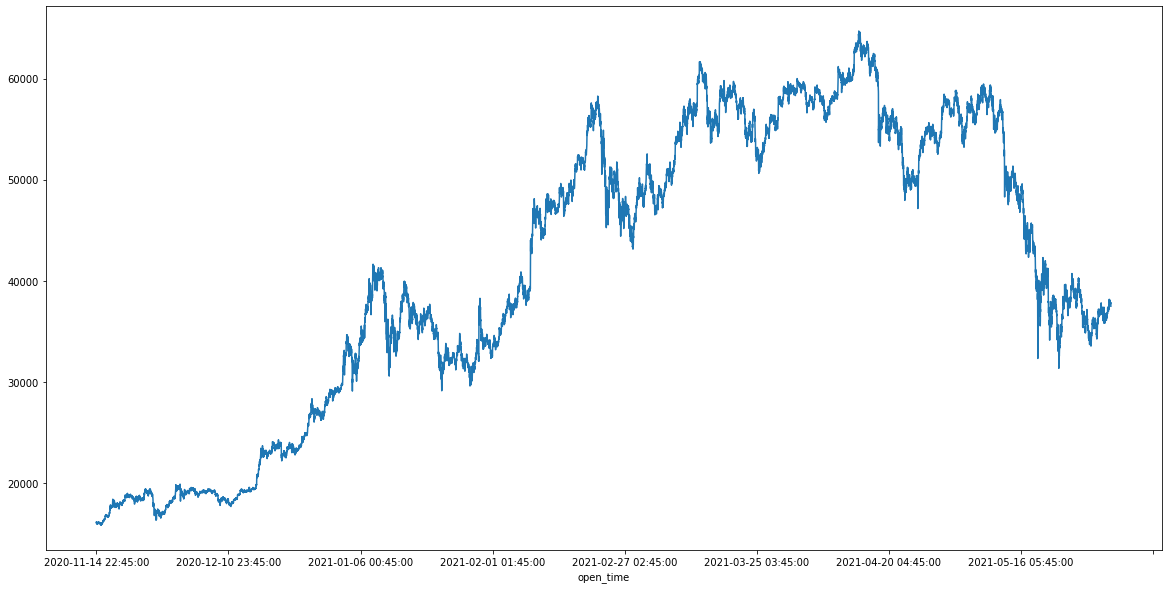

time: 365 ms (started: 2021-06-10 23:35:14 +00:00)


In [322]:
test_df = pd.read_csv("/drive/My Drive/disertation/test_df_{}_{}_candles_{}_class.csv".format(timeframe, candles, classes))
test_df = test_df.set_index("open_time")
test_df["close"].plot()

In [323]:
test_df.drop(columns=["close"],inplace=True)

data = test_df.to_numpy()
X_test = data[:,:-1]
Y_test = data[:,-1]

X_test, Y_test = extend_dataset_with_window_length(X_test, Y_test)

X_test = scaler.transform(X_test)
X_test.shape, Y_test.shape

((19191, 270), (19191,))

time: 1.28 s (started: 2021-06-10 23:35:14 +00:00)


In [324]:
Y_test_predicted = network.predict_classes(X_test)

print(np.array(np.unique(Y_test, return_counts=True)).T)
a,b = np.unique(Y_test, return_counts=True)
print("buy hold sell %")
print(b / sum(b))


print(np.array(np.unique(Y_test_predicted, return_counts=True)).T)
a,b = np.unique(Y_test_predicted, return_counts=True)
print("buy hold sell %")
print(b / sum(b))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[0.000e+00 9.670e+03]
 [1.000e+00 9.521e+03]]
buy hold sell %
[0.50388203 0.49611797]
[[    0 11905]
 [    1  7286]]
buy hold sell %
[0.62034287 0.37965713]
time: 480 ms (started: 2021-06-10 23:35:16 +00:00)


In [325]:
print(metrics.confusion_matrix(Y_test, Y_test_predicted))
print(metrics.classification_report(Y_test, Y_test_predicted, digits=3))

[[6218 3452]
 [5687 3834]]
              precision    recall  f1-score   support

         0.0      0.522     0.643     0.576      9670
         1.0      0.526     0.403     0.456      9521

    accuracy                          0.524     19191
   macro avg      0.524     0.523     0.516     19191
weighted avg      0.524     0.524     0.517     19191

time: 57.4 ms (started: 2021-06-10 23:35:16 +00:00)
